<a href="https://colab.research.google.com/github/MohUmaama/Budget_calculator/blob/main/budget_calculator_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive

=== Monthly Budget Calculator ===
1. Create New Budget
2. Load Existing Budget
3. Exit
Enter your choice: 1

--- Create New Budget ---
Enter your name: Umaama
Enter your currency (e.g., USD, LKR): USD
Enter conversion rate from USD to USD: 1
Enter your monthly income in USD: 555,000,000
Invalid input! Please enter a number.
Enter your monthly income in USD: 555000000
Enter your monthly savings goal in USD: 700000
Enter expense category (or 'done' to finish): study
Enter amount for Study in USD: 12000
Enter expense category (or 'done' to finish): Room
Enter amount for Room in USD: 6000
Enter expense category (or 'done' to finish): Food 
Enter amount for Food  in USD: 2000
Enter expense category (or 'done' to finish): Business
Enter amount for Business in USD: 80000
Enter expense category (or 'done' to finish): App building 
Enter amount for App Building  in USD: 90000
Enter expense category (or 'done' to finish): done

--- Budget Summary ---
Total Income: $555

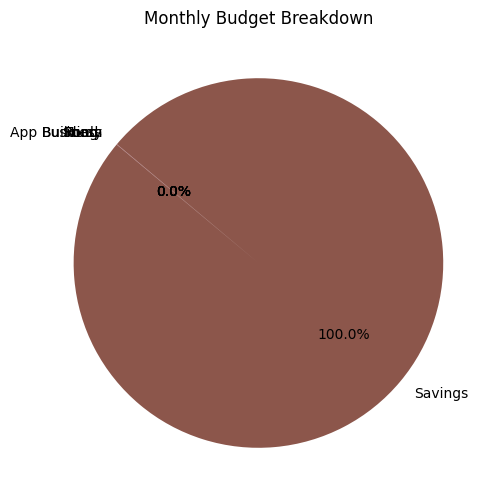

In [ ]:
import json
import os
import time
import datetime
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def get_user_file(username):
    """Generate user-specific file path"""
    return f"/content/drive/MyDrive/budget_{username.lower()}.json"

def main():
    """Main program loop"""
    while True:
        print_menu()
        choice = input("Enter your choice: ")

        if choice == "1":
            create_new_budget()
        elif choice == "2":
            load_budget()
        elif choice == "3":
            print("Goodbye!")
            break
        else:
            print("Invalid choice. Try again.")

def print_menu():
    """Display main menu options"""
    print("\n=== Monthly Budget Calculator ===")
    print("1. Create New Budget")
    print("2. Load Existing Budget")
    print("3. Exit")

def create_new_budget():
    """Create a new budget from user input"""
    print("\n--- Create New Budget ---")
    username = input("Enter your name: ").strip()
    DATA_FILE = get_user_file(username)

    currency = input("Enter your currency (e.g., USD, LKR): ").upper()
    conversion_rate = get_valid_float(f"Enter conversion rate from {currency} to USD: ", is_conversion_rate=True)

    income = get_valid_float(f"Enter your monthly income in {currency}: ")
    income_usd = income * conversion_rate

    goal = get_valid_float("Enter your monthly savings goal in USD: ")

    expenses = {}
    while True:
        category = input("Enter expense category (or 'done' to finish): ").title()
        if category.lower() == 'done':
            break
        amount = get_valid_float(f"Enter amount for {category} in {currency}: ")
        expenses[category] = amount * conversion_rate

    display_budget_summary(income_usd, expenses, goal)
    if input("\nSave this budget? (y/n): ").lower() == 'y':
        save_budget(income_usd, expenses, username)
    else:
        print("Budget not saved.")

def load_budget():
    """Load budget from file"""
    username = input("Enter your name: ").strip()
    DATA_FILE = get_user_file(username)

    if not os.path.exists(DATA_FILE):
        print("No saved budget found!")
        return

    try:
        with open(DATA_FILE, 'r') as f:
            data = json.load(f)

        print("\n--- Loaded Budget ---")
        goal = get_valid_float("Enter your monthly savings goal in USD: ")
        display_budget_summary(data['income'], data['expenses'], goal)

        if input("\nEdit this budget? (y/n): ").lower() == 'y':
            edit_budget(data, username, goal)

    except json.JSONDecodeError:
        print(f"Error decoding JSON from {DATA_FILE}. The file might be empty or corrupted.")
    except Exception as e:
        print(f"An error occurred while loading the budget: {e}")

def display_budget_summary(income, expenses, goal):
    """Display budget calculations and analysis"""
    total_expenses = sum(expenses.values())
    remaining = income - total_expenses

    print("\n--- Budget Summary ---")
    print(f"Total Income: ${income:.2f}")
    print("\nExpenses:")
    for category, amount in expenses.items():
        if income > 0:  # Prevent division by zero
          percent = (amount / income) * 100
          print(f"  {category}: ${amount:.2f} ({percent:.1f}%)")
        else:
          print(f"  {category}: ${amount:.2f}")


    print(f"\nTotal Expenses: ${total_expenses:.2f}")
    print(f"Remaining Balance: ${remaining:.2f}")

    if remaining < 0:
        print("⚠️ WARNING: You're overspending!")
    elif income > 0: # Prevent division by zero when calculating savings percentage
        savings_percent = (remaining / income) * 100
        print(f"✅ Savings Rate: {savings_percent:.1f}%")
        if remaining >= goal:
            print(f"🎉 You've met your savings goal of ${goal:.2f}!")
        else:
            print(f"📉 You're ${goal - remaining:.2f} short of your savings goal.")

    if income > 0: # Prevent plotting when income is zero
        plot_expenses(expenses, income)


def plot_expenses(expenses, income):
    """Display pie chart of expenses and savings"""
    labels = list(expenses.keys()) + ['Savings']
    values = list(expenses.values()) + [income - sum(expenses.values())]

    plt.figure(figsize=(6,6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Monthly Budget Breakdown')
    plt.show()


def edit_budget(data, username, goal):
    """Modify existing budget"""
    while True:
        print("\n--- Edit Budget ---")
        print("1. Change Income")
        print("2. Add/Update Expense")
        print("3. Delete Expense")
        print("4. Save and Exit")

        choice = input("Enter your choice: ")

        if choice == "1":
            data['income'] = get_valid_float("Enter new income in USD: ")
        elif choice == "2":
            category = input("Enter category name: ").title()
            amount = get_valid_float(f"Enter amount for {category} in USD: ")
            data['expenses'][category] = amount
        elif choice == "3":
            category = input("Enter category to delete: ").title()
            if category in data['expenses']:
                del data['expenses'][category]
            else:
                print("Category not found!")
        elif choice == "4":
            save_budget(data['income'], data['expenses'], username)
            break
        else:
            print("Invalid choice!")

        display_budget_summary(data['income'], data['expenses'], goal)

def save_budget(income, expenses, username):
    """Save budget to JSON file with timestamp"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"/content/drive/MyDrive/budget_{username.lower()}_{timestamp}.json"
    latest_file = get_user_file(username)

    data = {
        'income': income,
        'expenses': expenses
    }

    try:
        with open(filename, 'w') as f:
            json.dump(data, f)
        with open(latest_file, 'w') as f:
            json.dump(data, f)
        print(f"Budget saved as {filename}")
        time.sleep(1)
    except Exception as e:
        print(f"An error occurred while saving the budget: {e}")

def get_valid_float(prompt, is_conversion_rate=False):
    """Get valid numerical input from user"""
    while True:
        try:
            value = float(input(prompt))
            if value < 0:
                print("Please enter a positive number!")
                continue
            if is_conversion_rate and value == 0:
                print("Conversion rate cannot be zero!")
                continue
            return value
        except ValueError:
            print("Invalid input! Please enter a number.")

if __name__ == "__main__":
    main()